<a href="https://colab.research.google.com/github/Omoadonibetty/Hamoye_Internship/blob/main/Stage_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing all necessary Libraries

In [ ]:
import os
import cv2
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as img
from matplotlib.image import imread
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.metrics import fbeta_score
from os import listdir
import warnings
# filter warnings
warnings.filterwarnings('ignore')

2024-06-04 21:41:29.361989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 21:41:29.362117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 21:41:29.501109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

# Get list of files and directories in the "planets-dataset" directory
path = "../input/planets-dataset/"
dir_contents = os.listdir(path)

['planet', 'test-jpg-additional']

### Loading the image and the labelled datasets

In [ ]:
# Path to the training class labels (CSV file)
train_ = '../input/planets-dataset/planet/planet/train_classes.csv'

# Path to the test submission format specification (CSV file)
test_path = '../input/planets-dataset/planet/planet/sample_submission.csv'

# Path to the directory containing training images
train_images = '../input/planets-dataset/planet/planet/train-jpg/'

# Path to the directory containing test images
test_images = '../input/planets-dataset/planet/planet/test-jpg/'

# Path to an additional directory containing test images (if applicable)
test_additional = '/kaggle/input/planets-dataset/test-jpg-additional'

In [ ]:
# Path to the training class labels (CSV file)
train_path = '../input/planets-dataset/planet/planet/train_classes.csv'

# Read the training data labels from the CSV file using pandas
train_tags = pd.read_csv(train_path)

# Show the first few rows (head) of the loaded training data
print(train_tags.head(5))

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:


# Read training labels
train_tags = pd.read_csv(train_path)

# Read test submission format
  test_tags = pd.read_csv(test_path)
  test_tags.head(5)

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [ ]:
# Extract unique labels from training data
tags = train_tags["tags"].values  # Get tags as NumPy array
labels = [i.split(" ") for i in tags]  # Split tags into lists of labels
complete = sum(labels, [])  # Combine all labels into a single list
unique = set(complete)  # Remove duplicates using set
u_labels = list(unique)  # Convert unique labels back to list

print(u_labels)  # Display unique labels (optional)

['blooming',
 'habitation',
 'cultivation',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'blow_down',
 'selective_logging',
 'artisinal_mine',
 'slash_burn',
 'clear',
 'cloudy',
 'haze',
 'primary',
 'agriculture',
 'water',
 'road']

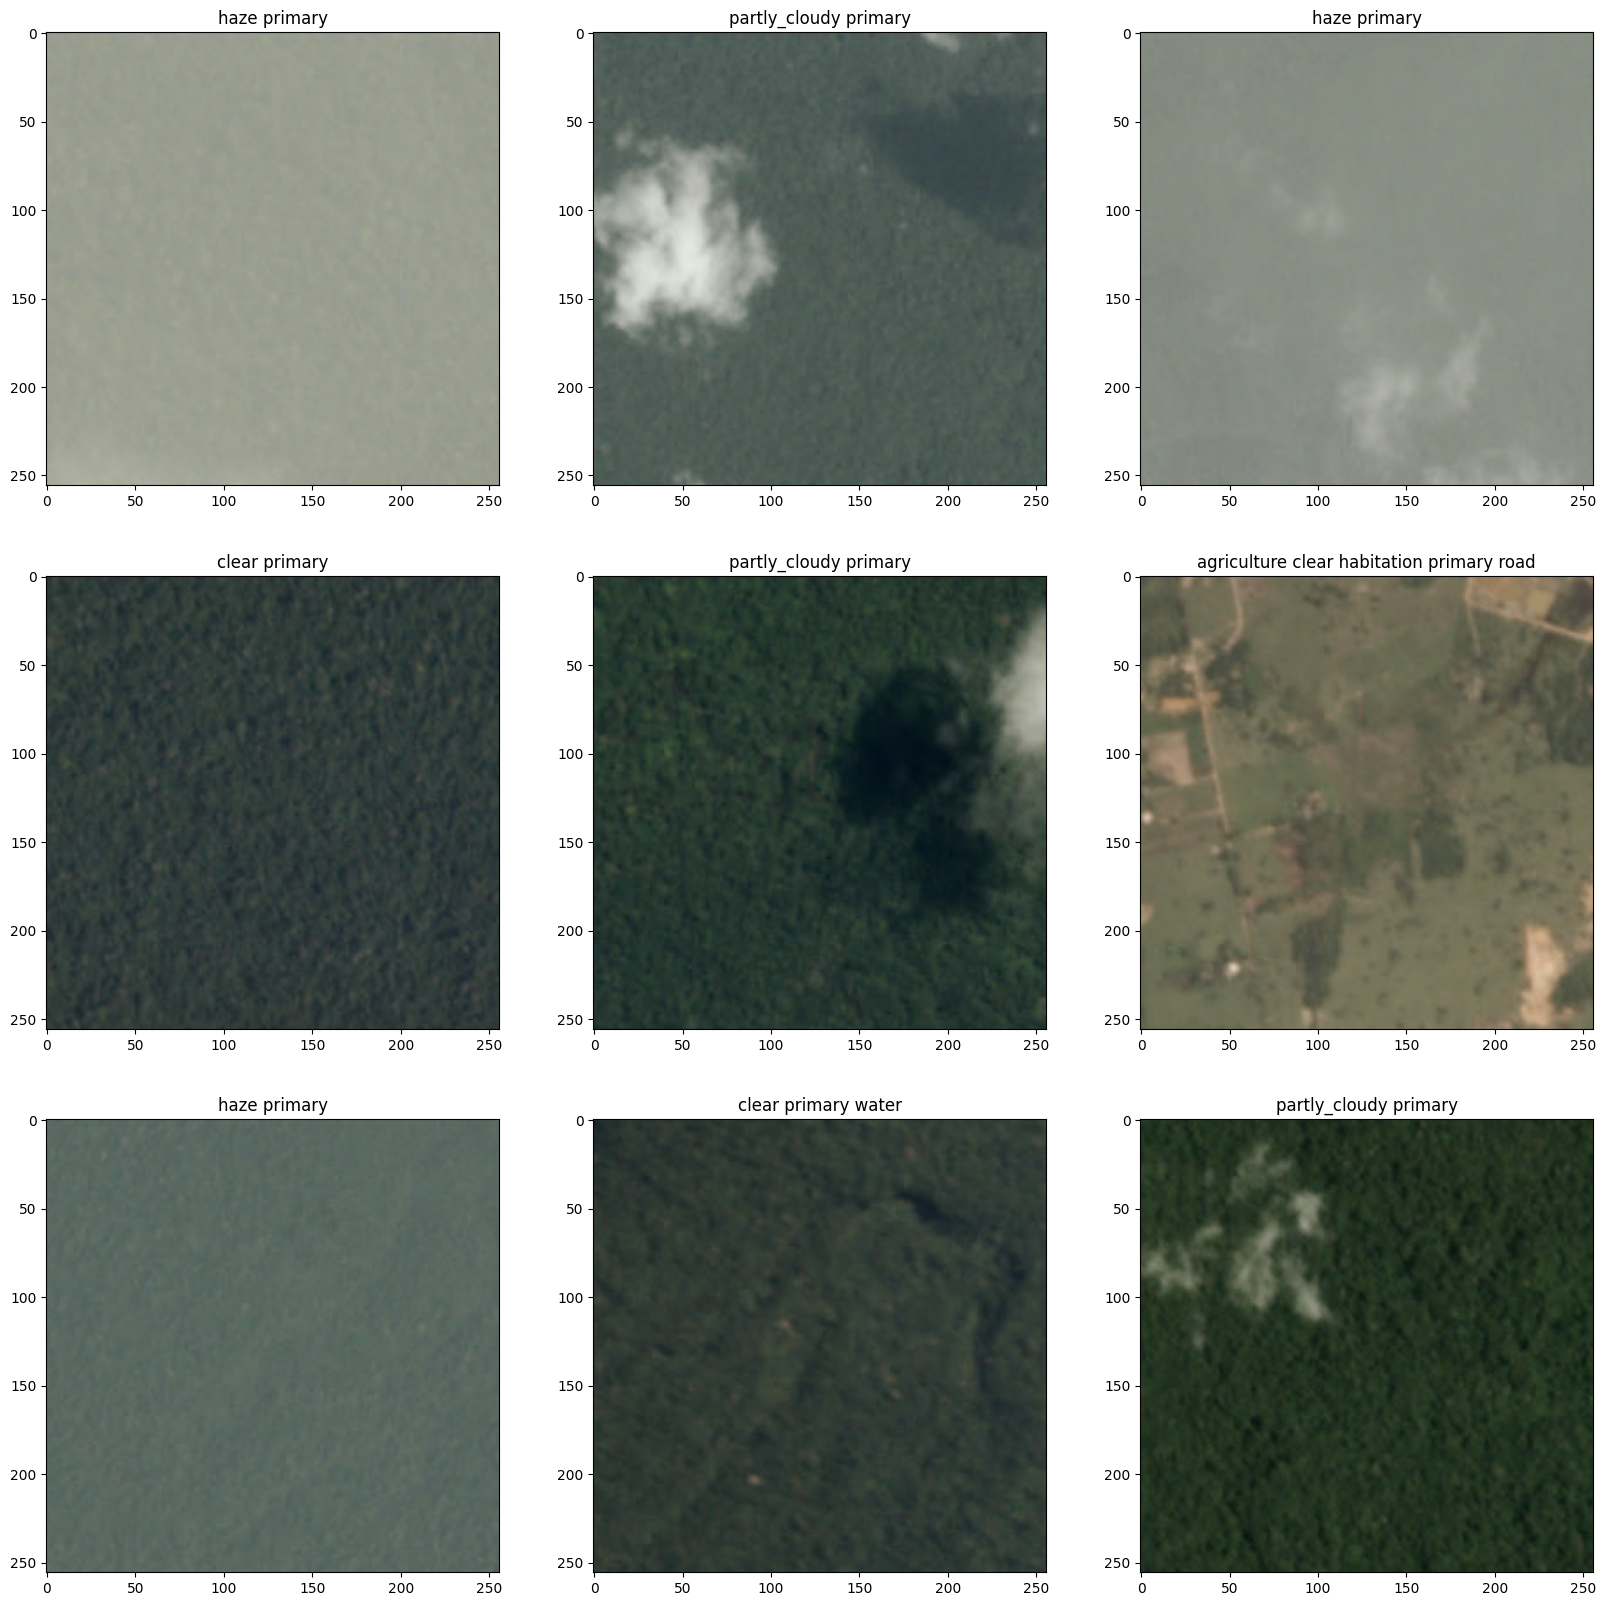

In [ ]:


# Number of images to display (9)
num_images = 9

# Randomly select image indices from training data (avoiding out-of-bounds)
max_index = train_tags.shape[0] - 1  # Get maximum valid index
image_indices = np.random.randint(0, max_index, num_images)

# Create a 3x3 grid of subplots with a larger figure size
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

# Loop through image indices and display images with titles
for i, image_idx in enumerate(image_indices):
    # Construct image path
    image_path = f'/kaggle/input/planets-dataset/planet/planet/train-jpg/train_{image_idx}.jpg'

    # Read image using OpenCV (assuming BGR format)
    img = cv2.imread(image_path)

    # Convert image to RGB for matplotlib display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display image on the current subplot
    ax[int(i // 3), i % 3].imshow(img_rgb)

    # Get the corresponding tag from training data and set as title
    tag = train_tags.iloc[image_idx, 1]  # Access tag at the selected index
    ax[int(i // 3), i % 3].set_title(tag)

# Remove extra whitespace around plots (optional)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:

# Path to the training image directory
train_image_dir = '/kaggle/input/planets-dataset/planet/planet/train-jpg/'

# Extract labels from the 'tags' column in train_tags DataFrame
labels = train_tags['tags'].str.split().explode().unique()

# Create a dictionary to map labels to unique indices
label_map = {label: i for i, label in enumerate(labels)}
inv_label_map = {i: label for label, i in label_map.items()}

# Empty lists to store training images and labels
train_images = []
train_one_hot_labels = []

# Loop through training data (with progress bar)
for file_name, tags_string in tqdm(train_tags.values, miniters=1000):
    # Construct image path
    image_path = f"{train_image_dir}{file_name}.jpg"

    # Read image using OpenCV (assuming BGR format)
    img = cv2.imread(image_path)

    # Create a zero-filled target vector (one-hot encoding)
    targets = np.zeros(len(labels), dtype=np.uint8)  # Pre-allocate for efficiency

    # Apply one-hot encoding for each tag in the string
    for tag in tags_string.split(' '):
        targets[label_map[tag]] = 1

    # Resize image for model compatibility (optional)
    resized_img = cv2.resize(img, (32, 32))  # Adjust dimensions as needed

    # Append processed image and target vector
    train_images.append(resized_img)
    train_one_hot_labels.append(targets)

# Convert lists to NumPy arrays for efficient processing
train_images = np.array(train_images, dtype=np.float16) / 255.0  # Normalize pixel values
train_one_hot_labels = np.array(train_one_hot_labels)

# Print the shapes of training data
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_one_hot_labels.shape)

100%|██████████| 40479/40479 [03:43<00:00, 181.23it/s]


Training data: (40479, 32, 32, 3), (40479, 17)


In [ ]:
#getting number of unique class combinations in the training set
train_tags["tags"].nunique()

449

### Merging the two test sets

In [ ]:
# merging test-jpg and test-jpg-additional
test_img = []

test_image_names = os.listdir(test_images)

n_test = len(test_image_names)
test_class = test_tags.iloc[:n_test, :]
add_class = test_tags.iloc[n_test:, :]

test_add_image_names = os.listdir(test_additional)

#read test images
#test = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

for f, tags in tqdm(test_class.values, miniters=1000):
    img = cv2.imread('/kaggle/input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    test_img.append(cv2.resize(img, (32, 32)))

for f, tags in tqdm(add_class.values, miniters=1000):
    img = cv2.imread('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    test_img.append(cv2.resize(img, (32, 32)))

test_img = np.array(test_img, np.float16) / 255.

100%|██████████| 20522/20522 [01:52<00:00, 182.28it/s]


### Splitting the training data

In [ ]:
# Splitting training data into training and validation sets

# Split ratio (adjustable): This value determines the proportion of data used for validation
split_ratio = 0.1  # Use 10% of data for validation

# Calculate number of samples for validation
num_validation_samples = int(split_ratio * len(train_images))

# Split training images and labels
x_train = train_images[:-num_validation_samples]
x_val = train_images[-num_validation_samples:]
y_train = train_labels[:-num_validation_samples]
y_val = train_labels[-num_validation_samples:]

print("Training images shape:", x_train.shape)
print("Validation images shape:", x_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

x_train: (35000, 32, 32, 3)
x_val: (5479, 32, 32, 3)
y_train: (35000, 17)
y_val: (5479, 17)


In [ ]:

def fbeta(y_true, y_pred, beta=2, epsilon=1e-4):
  """
  Calculates F-beta score for multi-label classification.

  Args:
      y_true: Ground truth labels, a tensor of shape (num_samples, num_classes).
      y_pred: Predicted probabilities, a tensor of shape (num_samples, num_classes).
      beta: Weighting factor between precision and recall (default: 2).
      epsilon: Small value to avoid division by zero (default: 1e-4).

  Returns:
      A tensor of shape (num_samples,) containing F-beta scores for each sample.
  """

  beta_squared = beta**2

  # Convert y_true to float32 for calculations
  y_true = tf.cast(y_true, tf.float32)

  # Convert predictions to one-hot encoding (if needed)
  # Assuming y_pred is probabilities, convert to one-hot with thresholding
  y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)

  # Calculate true positives, false positives, and false negatives
  tp = tf.reduce_sum(y_true * y_pred, axis=1)  # True positives
  fp = tf.reduce_sum(y_pred, axis=1) - tp  # False positives
  fn = tf.reduce_sum(y_true, axis=1) - tp  # False negatives

  # Calculate precision and recall with epsilon for stability
  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)

  # Calculate F-beta score
  fb = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)

  return fb

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
model = tf.keras.Sequential([
    # Add your model layers here (e.g., convolutional, pooling, dense)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Adjust hyperparameters as needed
              loss=BinaryCrossentropy(from_logits=True),  # Adjust loss function if needed
              metrics=[fbeta, multi_label_acc])  # Custom metrics

# Train the model
model.fit(x_train, y_train,
          epochs=10,  # Adjust number of epochs
          validation_data=(x_val, y_val))

In [1]:

def multi_label_acc(y_true, y_pred, epsilon=1e-4):
  """
  Calculates accuracy for multi-label classification.

  Args:
      y_true: Ground truth labels, a tensor of shape (num_samples, num_classes).
      y_pred: Predicted probabilities, a tensor of shape (num_samples, num_classes).
      epsilon: Small value to avoid division by zero (default: 1e-4).

  Returns:
      A tensor of shape (,) containing the overall accuracy.
  """

  # Cast y_true to float32 for calculations
  y_true = tf.cast(y_true, tf.float32)

  # Convert predictions to one-hot encoding (if needed)
  # Assuming y_pred is probabilities, convert to one-hot with thresholding
  y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)

  # Calculate true positives, false positives, and false negatives
  tp = tf.reduce_sum(y_true * y_pred, axis=1)  # True positives
  fp = tf.reduce_sum(y_pred, axis=1) - tp  # False positives
  fn = tf.reduce_sum(y_true, axis=1) - tp  # False negatives

  # Calculate true negatives
  # Cast y_true and y_pred to bool for logical operations
  y_true = tf.cast(y_true, tf.bool)
  y_pred = tf.cast(y_pred, tf.bool)
  tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), axis=1)

  # Calculate accuracy with epsilon for stability
  accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)

  # Return overall accuracy (average across samples)
  return tf.reduce_mean(accuracy)

In [ ]:

x_test = ...  # Test images
y_test = ...  # Test labels

# Make predictions
y_pred = model.predict(x_test)

# Evaluate on custom metrics
test_fbeta = fbeta(y_test, y_pred)
test_acc = multi_label_acc(y_test, y_pred)

print("F-beta score on test data:", test_fbeta.numpy())
print("Multi-label accuracy on test data:", test_acc.numpy())